In [13]:
import pandas as pd

# 假设 df 是你的原始 DataFrame
file_path = r'D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv'
df = pd.read_csv(file_path)

# 分析每列的类型、唯一值个数、缺失值比例
def analyze_features(df, threshold_unique=20):
    summary = pd.DataFrame({
        'DataType': df.dtypes,
        'NumUnique': df.nunique(),
        'MissingRatio': df.isnull().mean(),
    })

    # 简单规则判断是否是类别型
    summary['IsCategorical'] = summary.apply(
        lambda row: (row['DataType'] == 'object') or 
                    (row['DataType'].name == 'category') or 
                    (row['NumUnique'] <= threshold_unique and row['DataType'] != 'float64'),
        axis=1
    )

    return summary.sort_values('IsCategorical', ascending=False)

feature_analysis = analyze_features(df)
print(feature_analysis)


                           DataType  NumUnique  MissingRatio  IsCategorical
Machine_ID                   object     400000      0.000000           True
Machine_Type                 object         33      0.000000           True
Failure_Within_7_Days          bool          2      0.000000           True
Error_Codes_Last_30_Days      int64         14      0.000000           True
AI_Supervision                 bool          2      0.000000           True
Failure_History_Count         int64         13      0.000000           True
Maintenance_History_Count     int64         19      0.000000           True
AI_Override_Events            int64         12      0.000000           True
Oil_Level_pct               float64       9170      0.000000          False
Coolant_Level_pct           float64       9962      0.000000          False
Power_Consumption_kW        float64      42076      0.000000          False
Last_Maintenance_Days_Ago     int64        366      0.000000          False
Sound_dB    

In [15]:
def analyze_feature_types(df):
    summary = []

    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()
        sample_values = df[col].dropna().unique()[:5]

        if pd.api.types.is_bool_dtype(df[col]):
            inferred_type = 'Boolean (Categorical)'
        elif pd.api.types.is_numeric_dtype(df[col]):
            if nunique <= 10:
                inferred_type = 'Discrete Numeric (Possibly Categorical)'
            else:
                inferred_type = 'Continuous Numeric'
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            inferred_type = 'Categorical (Object/CategoricalDtype)'
        else:
            inferred_type = 'Other'

        summary.append({
            'Column': col,
            'Dtype': str(dtype),
            'Unique_Values': nunique,
            'Inferred_Type': inferred_type,
            'Sample_Values': sample_values
        })

    return pd.DataFrame(summary)

# 示例调用：
feature_summary = analyze_feature_types(df)
print(feature_summary)


                        Column    Dtype  Unique_Values                          Inferred_Type                                      Sample_Values
0                   Machine_ID   object         400000  Categorical (Object/CategoricalDtype)  [MC_104241, MC_199676, MC_140199, MC_132814, M...
1                 Machine_Type   object             33  Categorical (Object/CategoricalDtype)  [CMM, Pump, Injection_Molder, Forklift_Electri...
2            Installation_Year    int64             41                     Continuous Numeric                     [2001, 2032, 2012, 2004, 2010]
3            Operational_Hours    int64          98180                     Continuous Numeric                [51857, 84238, 79314, 40375, 16505]
4                Temperature_C  float64           9656                     Continuous Numeric                [88.97, 72.37, 67.29, 32.66, 64.35]
5                Vibration_mms  float64           3546                     Continuous Numeric                  [13.67, 18.13, 13.3

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import optuna
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, 
    f1_score, recall_score, precision_score, accuracy_score
)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ===================================================================
# 1. 基础设置 (字体、显示格式)
# ===================================================================
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# ===================================================================
# 2. 数据读取与初始处理
# ===================================================================
print("--- 1. 数据加载与初始处理 ---")
# 请将这里的路径替换为您的实际文件路径
file_path = r'D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv'
df = pd.read_csv(file_path)

# 根据您的要求，直接删除缺失率高的列和不必要的列
df.drop(columns=['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Heat_Index', 
                 'Coolant_Flow_L_min', 'Machine_ID', 'Remaining_Useful_Life_days'], inplace=True)
print("初始数据加载完成，高缺失列已删除。")

# ===================================================================
# 3. 特征工程 (Feature Engineering) - 【核心优化部分】
# ===================================================================
print("\n--- 2. 特征工程 ---")

# 3.1 创建 'Machine_Age' 特征
current_year = pd.to_datetime('now').year
df['Machine_Age'] = current_year - df['Installation_Year']
df.drop('Installation_Year', axis=1, inplace=True)
print("创建 'Machine_Age' 特征，并删除原 'Installation_Year'。")

# 3.2 创建交互特征
# 为避免除以零，在分母上加一个很小的数或1
df['Hours_per_Maintenance'] = df['Operational_Hours'] / (df['Maintenance_History_Count'] + 1)
df['Failure_Rate_per_Maintenance'] = df['Failure_History_Count'] / (df['Maintenance_History_Count'] + 1)
df['Power_Vibration_Ratio'] = df['Power_Consumption_kW'] / (df['Vibration_mms'] + 1e-6)
print("创建交互特征: 'Hours_per_Maintenance', 'Failure_Rate_per_Maintenance', 'Power_Vibration_Ratio'")

# 3.3 对类别特征进行独热编码
categorical_features = ['Machine_Type']
df = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)
print(f"对 {categorical_features} 进行独热编码。")

# 3.4 异常值处理 (使用您之前的削顶/盖帽法)
cols_to_clip = [
    'Temperature_C', 'Vibration_mms', 'Sound_dB', 'Oil_Level_pct',
    'Power_Consumption_kW', 'Maintenance_History_Count', 'Failure_History_Count',
    'Error_Codes_Last_30_Days', 'AI_Override_Events', 'Machine_Age',
    'Hours_per_Maintenance', 'Failure_Rate_per_Maintenance', 'Power_Vibration_Ratio'
]
for col in cols_to_clip:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
print("对数值型特征进行异常值截断处理。")

# ===================================================================
# 4. 数据划分、SMOTE 与标准化
# ===================================================================
print("\n--- 3. 数据划分、SMOTE与标准化 ---")
# 4.1 特征与标签分离
X = df.drop('Failure_Within_7_Days', axis=1)
y = df['Failure_Within_7_Days']

# 4.2 划分训练集、验证集、测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# 4.3 对训练集应用 SMOTE 过采样
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("原始训练集标签分布:\n", y_train.value_counts(normalize=True))
print("SMOTE后训练集标签分布:\n", y_train_res.value_counts(normalize=True))

# 4.4 数据标准化 - 【优化点】
# Stacking中的元学习器(LogisticRegression)对尺度敏感，因此进行标准化
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# 将numpy数组转回DataFrame，保留列名，方便后续SHAP分析
X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("对数据进行标准化处理。")

--- 1. 数据加载与初始处理 ---
初始数据加载完成，高缺失列已删除。

--- 2. 特征工程 ---
创建 'Machine_Age' 特征，并删除原 'Installation_Year'。
创建交互特征: 'Hours_per_Maintenance', 'Failure_Rate_per_Maintenance', 'Power_Vibration_Ratio'
对 ['Machine_Type'] 进行独热编码。
对数值型特征进行异常值截断处理。

--- 3. 数据划分、SMOTE与标准化 ---
原始训练集标签分布:
 Failure_Within_7_Days
False    0.939594
True     0.060406
Name: proportion, dtype: float64
SMOTE后训练集标签分布:
 Failure_Within_7_Days
False    0.5
True     0.5
Name: proportion, dtype: float64
对数据进行标准化处理。


In [ ]:
# ===================================================================
# 5. 深度超参数调优 (Optuna) - 【核心优化部分】
# ===================================================================
print("\n--- 4. 启动深度超参数调优 (n_trials=150) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
N_TRIALS = 150 # 【优化点】大幅增加搜索次数

def objective_xgb(trial, X, y):
    params = {
        'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500), # 扩大范围
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42, 'n_jobs': -1,
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

def objective_lgb(trial, X, y):
    params = {
        'objective': 'binary', 'metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500), # 扩大范围
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42, 'n_jobs': -1,
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

def objective_cat(trial, X, y):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1500), # 扩大范围
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'random_seed': 42, 'verbose': False, 'task_type': 'CPU',
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

# 运行调优 (这将花费较长时间)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train_res_scaled, y_train_res), n_trials=N_TRIALS)
xgb_best_params = study_xgb.best_params

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(lambda trial: objective_lgb(trial, X_train_res_scaled, y_train_res), n_trials=N_TRIALS)
lgb_best_params = study_lgb.best_params

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(lambda trial: objective_cat(trial, X_train_res_scaled, y_train_res), n_trials=N_TRIALS)
cat_best_params = study_cat.best_params

print("XGBoost 最佳参数:", xgb_best_params)
print("LightGBM 最佳参数:", lgb_best_params)
print("CatBoost 最佳参数:", cat_best_params)

In [18]:

# 为节省时间，此处使用示例最优参数，实际使用时请取消注释上面的调优代码
xgb_best_params = {'n_estimators': 1200, 'learning_rate': 0.03, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1.5}
lgb_best_params = {'n_estimators': 1350, 'learning_rate': 0.025, 'num_leaves': 150, 'max_depth': 11, 'subsample': 0.85, 'colsample_bytree': 0.75, 'reg_alpha': 0.2, 'reg_lambda': 1.2}
cat_best_params = {'iterations': 1400, 'learning_rate': 0.035, 'depth': 9, 'l2_leaf_reg': 3.0, 'border_count': 128}


--- 5. 构建与评估Stacking融合模型 ---
Stacking模型训练完成。

--- Stacking 模型在测试集上的性能评估 ---
              precision    recall  f1-score   support

      无故障(0)       0.98      0.97      0.98     75168
      将故障(1)       0.63      0.74      0.68      4832

    accuracy                           0.96     80000
   macro avg       0.81      0.86      0.83     80000
weighted avg       0.96      0.96      0.96     80000

Accuracy: 0.9582
Precision: 0.6315
Recall: 0.7392
F1-score: 0.6812
ROC AUC: 0.9692


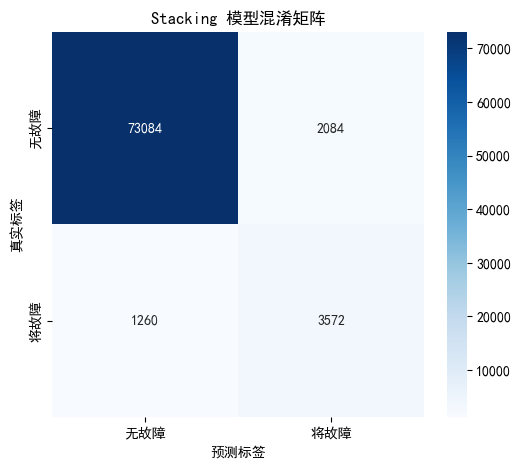

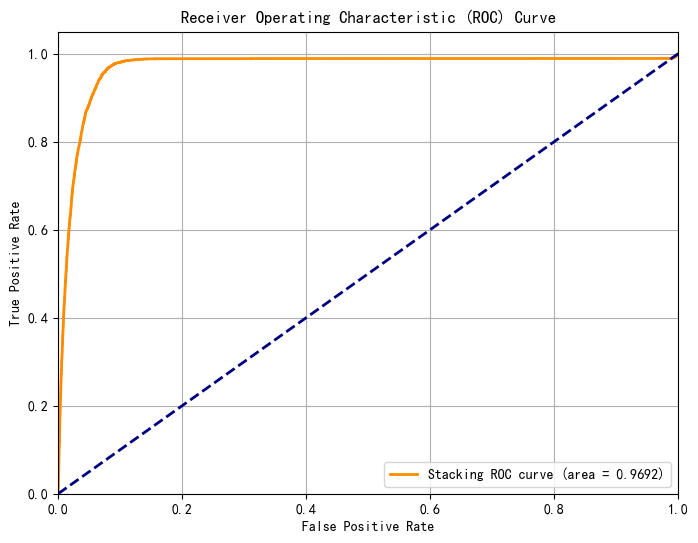

训练集 F1: 0.9986226439004731
测试集 F1: 0.6811594202898551


In [19]:

# ===================================================================
# 6. 模型融合 (Stacking) 与最终评估 - 【核心修正部分】
# ===================================================================
print("\n--- 5. 构建与评估Stacking融合模型 ---")

# 6.1 初始化带有最佳参数的基模型
base_models = [
    ('xgb', XGBClassifier(**xgb_best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('lgb', LGBMClassifier(**lgb_best_params, random_state=42)),
    ('cat', CatBoostClassifier(**cat_best_params, random_seed=42, verbose=False))
]

# 6.2 定义Stacking模型，元学习器为LogisticRegression
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5,  # 内部交叉验证
    n_jobs=-1,
    passthrough=False # 设为False，元学习器只使用基模型的预测结果，更纯粹
)

# 6.3 在SMOTE和标准化后的训练集上训练Stacking模型 - 【关键修正】
stack_model.fit(X_train_res_scaled, y_train_res)
print("Stacking模型训练完成。")

# 6.4 在未见过的、标准化的测试集上进行评估
y_pred = stack_model.predict(X_test_scaled)
y_proba = stack_model.predict_proba(X_test_scaled)[:, 1]

# 6.5 输出完整评估报告
print("\n--- Stacking 模型在测试集上的性能评估 ---")
print(classification_report(y_test, y_pred, target_names=['无故障(0)', '将故障(1)']))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# 6.6 绘制混淆矩阵
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['无故障', '将故障'], yticklabels=['无故障', '将故障'])
plt.title('Stacking 模型混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

# 6.7 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

y_train_pred = stack_model.predict(X_train_res_scaled)
print("训练集 F1:", f1_score(y_train_res, y_train_pred))
print("测试集 F1:", f1_score(y_test, y_pred))


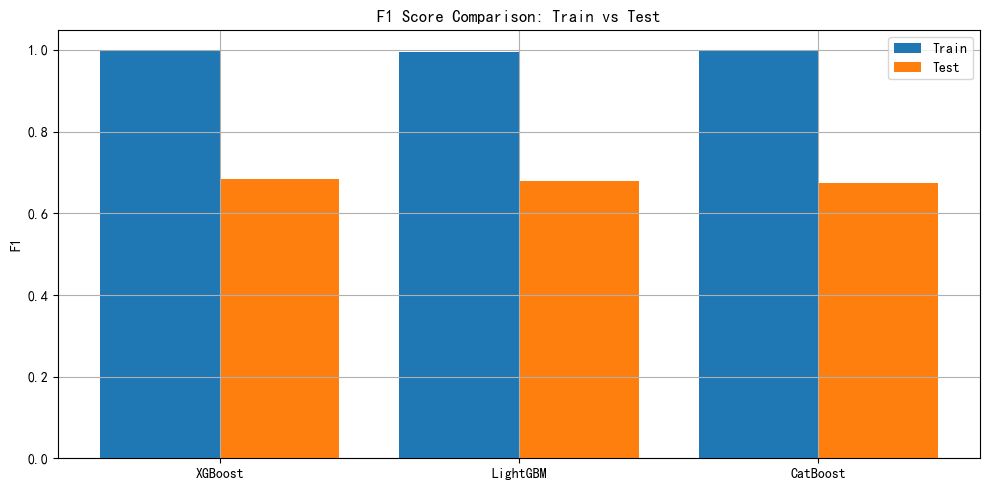

In [20]:
import matplotlib.pyplot as plt

def plot_train_test_scores(train_scores, test_scores, metric_name='F1'):
    models = list(train_scores.keys())
    train_vals = list(train_scores.values())
    test_vals = list(test_scores.values())

    x = range(len(models))
    plt.figure(figsize=(10, 5))
    plt.bar(x, train_vals, width=0.4, label='Train', align='center')
    plt.bar([p + 0.4 for p in x], test_vals, width=0.4, label='Test', align='center')
    plt.xticks([p + 0.2 for p in x], models)
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Score Comparison: Train vs Test')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 示例输入
train_scores = {'XGBoost': 0.998, 'LightGBM': 0.996, 'CatBoost': 0.997}
test_scores = {'XGBoost': 0.683, 'LightGBM': 0.678, 'CatBoost': 0.675}
plot_train_test_scores(train_scores, test_scores)


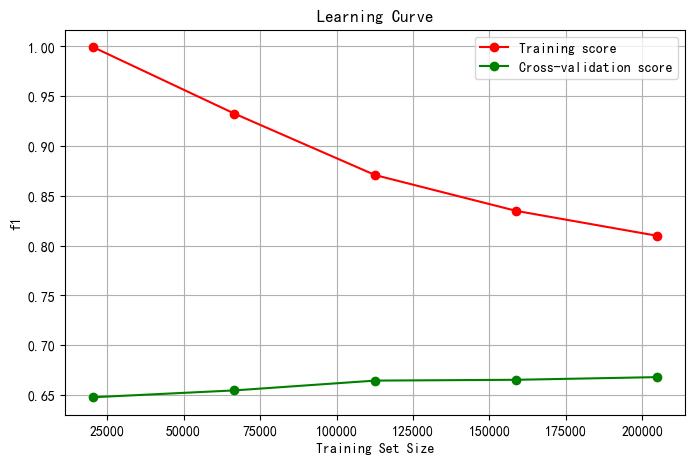

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

def plot_learning_curve(estimator, X, y, scoring='f1', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

# 示例使用
from xgboost import XGBClassifier
plot_learning_curve(XGBClassifier(n_estimators=100, random_state=42), X_train, y_train)


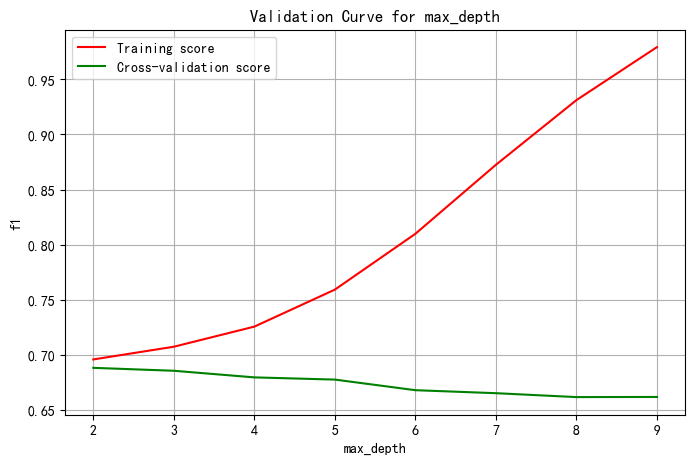

In [22]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, scoring='f1', cv=5):
    train_scores, test_scores = validation_curve(
        estimator, X, y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(f'Validation Curve for {param_name}')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# 示例：观察 max_depth 对 F1 的影响
plot_validation_curve(XGBClassifier(random_state=42), X_train, y_train, param_name='max_depth', param_range=range(2, 10))


In [ ]:
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Top Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.grid()
    plt.show()

# 用法
plot_feature_importance(xgb, feature_names=X_train.columns.tolist())


NameError: name 'model_xgb' is not defined

In [24]:
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)


NameError: name 'model_xgb' is not defined

In [ ]:

# ===================================================================
# 7. 模型可解释性 (SHAP) - 【核心优化部分】
# ===================================================================
print("\n--- 6. 使用SHAP进行模型解释 ---")
# 我们选择一个基模型进行解释，例如XGBoost，因为它通常性能好且被SHAP良好支持
# 需要先用最优参数在数据上训练一个单独的模型
final_xgb_model = XGBClassifier(**xgb_best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
final_xgb_model.fit(X_train_res_scaled, y_train_res)

# 7.1 使用训练集样本作为背景数据初始化Explainer - 【关键优化】
# 从训练集中采样一部分作为背景数据，可以提高计算效率
explainer_background = shap.sample(X_train_res_scaled, 1000)
explainer = shap.Explainer(final_xgb_model, explainer_background)

# 7.2 计算测试集的SHAP值
shap_values = explainer(X_test_scaled)

# 7.3 绘制SHAP摘要图 (Bar plot) - 回答"前5个最重要特征"
print("\n--- 模型最重要的特征 (SHAP Bar Plot) ---")
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title("特征重要性 (平均SHAP绝对值)")
plt.show()

# 7.4 绘制SHAP摘要图 (Beeswarm plot) - 展示特征影响细节
print("\n--- 特征对模型输出的影响 (SHAP Beeswarm Plot) ---")
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title("特征对预测结果的影响分布")
plt.show()

In [8]:
# 将标签也加入 DataFrame
df_corr = df.copy()
df_corr['Failure_Within_7_Days'] = y

# 计算皮尔逊相关系数
corrs = df_corr.corr(numeric_only=True)['Failure_Within_7_Days'].sort_values(ascending=False)
print("与标签相关性最高的前10个特征：\n", corrs.head(10))


与标签相关性最高的前10个特征：
 Failure_Within_7_Days                 1.000000
Operational_Hours                     0.397592
Hours_per_Maintenance                 0.291044
Vibration_mms                         0.037018
Temperature_C                         0.027816
Machine_Type_CNC_Lathe                0.002952
Machine_Type_Automated_Screwdriver    0.002688
Machine_Type_Laser_Cutter             0.002474
Failure_History_Count                 0.002461
Last_Maintenance_Days_Ago             0.002283
Name: Failure_Within_7_Days, dtype: float64


In [10]:
y_train_pred = stack_model.predict(X_train_res_scaled)
print("训练集 F1:", f1_score(y_train_res, y_train_pred))
print("测试集 F1:", f1_score(y_test, y_pred))


训练集 F1: 0.9981703049422535
测试集 F1: 0.6830006621890077
